In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ML-LaDECO/LaDECO

/content/drive/MyDrive/ML-LaDECO/LaDECO


In [ ]:
import numpy as np

print('Project MLaDECO')
print('Author: Viswambhar Yasa')
print('Software version: 0.1')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import models
from thermograms.Utilities import Utilities
from ml_training.dataset_generation.fourier_transformation import fourier_transformation
from ml_training.dataset_generation.principal_componant_analysis import principal_componant_analysis
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
from utilites.tolerance_maks_gen import tolerance_predicted_mask
from utilites.thermal_profile import thermal_error_estimation
import matplotlib.pyplot as plt

Project MLaDECO
Author: Viswambhar Yasa
Software version: 0.1


In [ ]:
root_path = r'utilites/datasets'
data_file_name = r'Parameterstudie_data.hdf5'
thermal_class = Utilities()
thermal_data,experiment_list=thermal_class.open_file(root_path, data_file_name,True)
experiment_name=r'2021-11-24-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit'
experimental_data=thermal_data[experiment_name] 

Experiments in the file 

1  :  2021-11-24-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit
2  :  2021-12-02-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit


A total of 2 experiments are loaded in file  



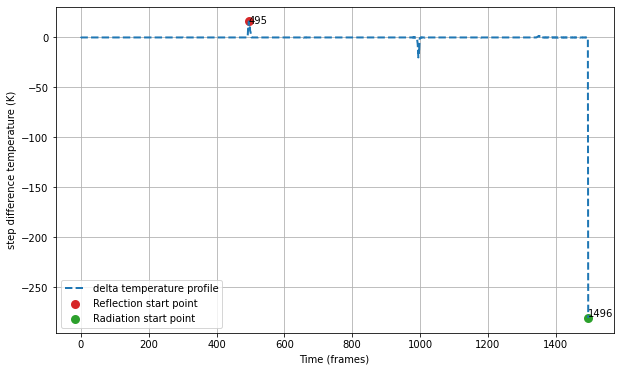

In [ ]:
thermal_error_estimation(experimental_data)

In [ ]:
experimental_data=experimental_data[:,:,:-5]

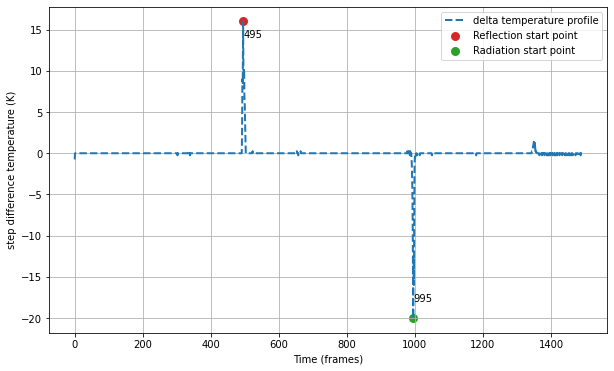

In [ ]:
thermal_error_estimation(experimental_data)

In [ ]:
input_data, reflection_st_index, reflection_end_index = fourier_transformation(experimental_data,
                                                                               scaling_type='normalization', index=1)

reflection_start_index:  486   reflection_end_index:  993
The size of filtered data: (256, 256, 507)


In [ ]:
thermal_net = models.load_model(r'trained_models/UNet/u_net_64_Adam_5_best_agu.h5')

In [ ]:
expanded_input_data = np.expand_dims(input_data, axis=0)

In [ ]:
data=np.expand_dims(expanded_input_data[:,:,:,250],axis=-1)
predicted_mask = thermal_net.predict(data)
final_mask = tolerance_predicted_mask(predicted_mask, tol=0.5)

In [ ]:
anno_path=r'ml_training/dataset_generation/annots/'

In [ ]:
file_path=anno_path+experiment_name+'.npy'
np.save(file_path,final_mask)

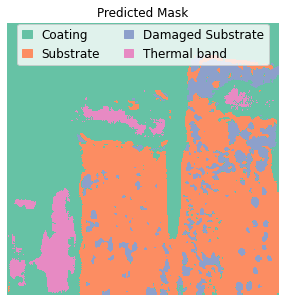

In [ ]:
segmentation_colormap_anno(final_mask, heatmap='RdYlBu_r', file_name=experiment_name, disp=True)

In [ ]:
experiment_list

{0: '2021-11-24-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit',
 1: '2021-12-02-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit'}

In [ ]:
from ml_training.dataset_generation.data_preprocessing import data_preprocessing_depth,depth_annotations

ImportError: ignored

In [ ]:
thickness_list=[-0.08,-0.1,0.5,-0.08,-0.1,0.5]

In [ ]:
y_training_ds=depth_annotations(experiment_list,thickness_list)

In [ ]:
anno_path=r'ml_training/dataset_generation/annots/'

In [ ]:
x_training_ds=data_preprocessing_depth(thermal_data,experiment_list,anno_path)

2021-11-24-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit
reflection_start_index:  486  reflection_end_index:  1003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


2021-12-02-Parameterstudie-1000W_Halogenstrahler-10s_Belichtungszeit
reflection_start_index:  468  reflection_end_index:  974


In [ ]:
from therml.ml_models import Depth_estimation

In [ ]:
class Depth_estimation:

    def __init__(self,number_of_features=3,no_of_time_steps=200):
        self.number_of_features=number_of_features
        self.no_of_time_steps=no_of_time_steps
        pass

    def depth_model(self,type='GRU',disp=False):
        if type=='GRU':
            depth_model=tf.keras.Sequential([
                               tf.keras.layers.Input(shape=(self.no_of_time_steps,self.number_of_features))
                               ,tf.keras.layers.GRU(512,return_sequences=True,dropout=0.2)
                               ,tf.keras.layers.GRU(512,return_sequences=True,dropout=0.2)
                               ,tf.keras.layers.GRU(256,return_sequences=True,dropout=0.1)
                               ,tf.keras.layers.GRU(128)
                               ,tf.keras.layers.Dense(256,activation='relu')
                               ,tf.keras.layers.Dense(self.number_of_features,activation='softmax')])
        elif type=='Bi-GRU':
            depth_model=tf.keras.Sequential([
                               tf.keras.layers.Input(shape=(self.no_of_time_steps,self.number_of_features))
                               ,tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512,return_sequences=True,dropout=0.1))
                               ,tf.keras.layers.GRU(256,return_sequences=True,dropout=0.1)
                               ,tf.keras.layers.GRU(128)
                               ,tf.keras.layers.Dense(256,activation='relu')
                               ,tf.keras.layers.Dense(self.number_of_features,activation='softmax')])
        elif type=='LSTM' :
            depth_model=tf.keras.Sequential([
                               tf.keras.layers.Input(shape=(self.no_of_time_steps,self.number_of_features))
                               ,tf.keras.layers.LSTM(512,return_sequences=True,dropout=0.2)
                               ,tf.keras.layers.LSTM(512,return_sequences=True,dropout=0.2)
                               ,tf.keras.layers.LSTM(256,return_sequences=True,dropout=0.1)
                               ,tf.keras.layers.LSTM(128)
                               ,tf.keras.layers.Dense(256,activation='relu')
                               ,tf.keras.layers.Dense(self.number_of_features,activation='softmax')])
        else :
            depth_model=tf.keras.Sequential([
                               tf.keras.layers.Input(shape=(self.no_of_time_steps,self.number_of_features))
                               ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True,dropout=0.2))
                               ,tf.keras.layers.GRU(256,return_sequences=True,dropout=0.1)
                               ,tf.keras.layers.GRU(128)
                               ,tf.keras.layers.Dense(256,activation='relu')
                               ,tf.keras.layers.Dense(self.number_of_features,activation='softmax')])
        if disp:
            tf.keras.utils.plot_model(
            depth_model, to_file='thickness_estimation_arch.png', show_shapes=True)
            depth_model.summary()
        return depth_model
        

In [ ]:
depth_nn=Depth_estimation()

In [ ]:
depth_model_Bi_GRU=depth_nn.depth_model(type='Bi-GRU')

In [ ]:
depth_model_Bi_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 200, 1024)        1588224   
 nal)                                                            
                                                                 
 gru_18 (GRU)                (None, 200, 256)          984576    
                                                                 
 gru_19 (GRU)                (None, 128)               148224    
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,754,819
Trainable params: 2,754,819
Non-trainable params: 0
____________________________________________

In [ ]:
x_training_ds[np.isnan(x_training_ds)] = 0

In [ ]:
x_training_ds.shape,y_training_ds.shape

((2, 200, 3), (2, 3))

In [ ]:
depth_model_Bi_GRU.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.losses.mean_squared_error,
                        metrics=tf.metrics.RootMeanSquaredError())

In [ ]:
stopping_criteria=tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', baseline=0.90, patience=5)

In [ ]:
model_history=depth_model_Bi_GRU.fit(x_training_ds,y_training_ds,epochs=500)#,callbacks=stopping_criteria)

Epoch 1/500
1/1 [==============================] - 16s 16s/step - loss: 0.1288 - root_mean_squared_error: 0.3589
Epoch 2/500
1/1 [==============================] - 3s 3s/step - loss: 0.1253 - root_mean_squared_error: 0.3540
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 0.1163 - root_mean_squared_error: 0.3410
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 0.1008 - root_mean_squared_error: 0.3175
Epoch 5/500
1/1 [==============================] - 3s 3s/step - loss: 0.0727 - root_mean_squared_error: 0.2697
Epoch 6/500
1/1 [==============================] - 3s 3s/step - loss: 0.0520 - root_mean_squared_error: 0.2281
Epoch 7/500
1/1 [==============================] - 3s 3s/step - loss: 0.0711 - root_mean_squared_error: 0.2666
Epoch 8/500
1/1 [==============================] - 3s 3s/step - loss: 0.0704 - root_mean_squared_error: 0.2654
Epoch 9/500
1/1 [==============================] - 3s 3s/step - loss: 0.0599 - root_mean_squared_error: 0.2447

In [ ]:
model_para=model_history.history

In [ ]:
model_para=model_history.history
path=r'trained_models\GRU\model_history'

In [ ]:
filename="\depth_estimatin_Bi_GRU_Adam_001.pkl"
file_path=path+filename
import pickle

# define dictionary

# create a binary pickle file 
f = open(file_path,"wb")

# write the python object (dict) to pickle file
pickle.dump(model_para,f)
# close file
f.close()

In [ ]:
depth_model_Bi_GRU.evaluate(x_training_ds,y_training_ds)

In [ ]:
y_predicted=depth_model_Bi_GRU.predict_on_batch(x_training_ds)

In [ ]:
y_training_ds,np.argmax(y_predicted,axis=1)

In [ ]:
model_save_path=r'trained_models/GRU'

In [ ]:
model_name=r'/depth_estmation_Bi_GRU_adam.h5'
model_path=model_save_path+model_name
depth_model_Bi_GRU.save(model_path,overwrite=False)